In [1]:
################# 正式分析脚本 #################
import pandas as pd
import re
from IPython.display import display, Markdown
from typing import List, Optional, Union
from elasticsearch import Elasticsearch

es = Elasticsearch(hosts="10.0.1.107", http_auth=("elastic", "8ec1f622cdc1f07c7b21beeeaf8d21f3"), port=9200, timeout=30, max_retries=3, retry_on_timeout=True)

file_paths = [
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1012_1822311(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1828837(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1015_1822327(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1828855(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1836221(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1011_1836221(2).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1835723(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1015_1835285(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1012_1836223(1).xlsx",
        "C:\\Users\\xxxlll\\Desktop\\东奥\\主观题判分数据\\1004_1013_1835723(2).xlsx",
        ]
results = []
subject_name = pd.DataFrame({
    "subject_id": [1010, 1011, 1012, 1013, 1014, 1015],
    "subject_name": ["审计","税法", "经济法", "财管", "会计", "战略"],
})

for idx, path in enumerate(file_paths):
    df = pd.read_excel(path)
    # 模型得分列识别
    model_score_col = None
    for name in ["AI打分", "系统判分", "程序-用户得分"]:
        if name in df.columns:
            model_score_col = name
            break

    # 最小得分点提取函数
    def extract_min_point(row):
        for json_col in ["AI输出", "结果"]:
            if json_col in df.columns and isinstance(row.get(json_col), str):
                try:
                    corrected_json_str = row[json_col].replace("null", 'None')
                    json_col_res = eval(corrected_json_str)
                    data = json_col_res
                    try:
                        question_type = data['question_name']
                        scores = [item['scores']['score'] for item in data['correct_answers_scores'] if 'scores' in item and 'score' in item.get('scores', {})]
                        min_score = min(scores) if scores else None
                        lose_points_messages = []
                        # 提取 correct_answers_scores 中非空的 lose_points
                        for item in data.get('student_scores', []):
                            if 'scores' in item and item['scores'].get('lose_points'):
                                for lp in item['scores']['lose_points']:
                                    if 'message' in lp and 'score' in lp:
                                        lose_points_messages.append(f"{lp['message']}_{lp['score']}")
                        lose_point_res = '|'.join(map(str, lose_points_messages)) if lose_points_messages else ''
                        return min_score, lose_point_res, question_type
                    except KeyError as e:
                        print(corrected_json_str)
                        print(f"Key error: {e}")
                        return None, '', ''
                finally:
                    pass
        pattern = re.compile(r"程序-正确.*分值\d*")
        candidates = [row[col] for col in row.index if pattern.match(col) and pd.notna(row[col])]
        return min(candidates) if candidates else None, '', ''

    df[['最小得分点', '失分原因', "判分类型"]] = df.apply(lambda row: extract_min_point(row), axis=1, result_type='expand')

    # 提取指定列
    parsed = df[["科目ID", "用户ID", "试题ID", "试题分数", "判分类型", "boss-用户得分", model_score_col, "最小得分点", "失分原因"]].copy()
    parsed.columns = ["subject_id", "user_id", "question_id", "question_score", "question_type", "teacher_score", "model_score", "min_point", "lose_points"]
    paper_id_info =  path.rsplit('.', 1)[0].rsplit('_', 1)[-1] # re.search(r'_(\d+?)\(', path)
    if paper_id_info:
        # 提取并打印找到的数字
        paper_id = paper_id_info  # paper_id_info.group(1)
        print(f"提取的试卷id是: {paper_id}")
    else:
        paper_id  = 0
        print("没有找到匹配的数字")
    parsed["paper_id"] = paper_id
    results.append(parsed)
final_df = pd.concat(results, ignore_index=True)
final_df = final_df.merge(subject_name, on="subject_id")
final_df.drop(columns=["subject_id"], inplace=True)

# 删除模型暂不支持的数据
final_df_1 =  final_df[~((final_df['question_type'] == '表格') & (final_df['model_score'] == 0))] # 财管表格但学生答案是文本


提取的试卷id是: 1822311(1)
提取的试卷id是: 1828837(1)
提取的试卷id是: 1822327(1)
提取的试卷id是: 1828855(1)
提取的试卷id是: 1836221(1)
提取的试卷id是: 1836221(2)
提取的试卷id是: 1835723(1)
提取的试卷id是: 1835285(1)
提取的试卷id是: 1836223(1)
提取的试卷id是: 1835723(2)


In [20]:
################# 分析函数 ##################

def calculate_percentage_within_margin(prob: float, group: pd.DataFrame) -> float:
    """计算误差在给定百分比范围内的比例"""
    lower_bound = -prob * group['question_score']
    upper_bound = prob * group['question_score']
    within_margin = ((group['score_error'] >= lower_bound) & (group['score_error'] <= upper_bound))
    return within_margin.mean()

def classify_error(error: float) -> str:
    """分类误差类型"""
    if error == 0:
        return '完全匹配'
    return '模型偏高' if error > 0 else '模型偏低'
    
def is_precise_match(error: float, acceptable_error: Union[float, str], rule_type: int) -> bool:
    """检查是否为精准匹配"""
    if rule_type == 3:
        lower_bound, upper_bound = map(float, acceptable_error.split('_'))
        return lower_bound <= error <= upper_bound
    return -acceptable_error < error < acceptable_error

def calculate_percentage_error(row: pd.Series, percentage: float) -> bool:
    """计算误差是否在给定百分比范围内"""
    question_score = row['question_score']
    score_error = row['score_error']
    margin = question_score * percentage / 100.0
    return -margin <= score_error <= margin

def find_group_id(question_list: List[str]) -> Optional[pd.DataFrame]:
    """查找问题组ID"""
    body = {
        "query": {
            "terms": {
                "question_id": question_list
            }
        },
        "size": 10,
        "_source": ["group_id", "question_id"]
    }
    response = es.search(index='biz_question_v2', body=body)
    if not response['hits']['total']['value']:
        return None
    return pd.DataFrame([hit['_source'] for hit in response['hits']['hits']])

def _calculate_common_metrics(grouped_data: pd.core.groupby.generic.DataFrameGroupBy, group_key: List[str]) -> pd.DataFrame:
    """计算通用指标（内部函数）"""
    # 初始化结果DataFrame
    stats = grouped_data.size().reset_index(name='count')
    
    # 计算各类误差比例
    error_classes = grouped_data['error_class'].value_counts(normalize=True).unstack().fillna(0)
    stats = stats.merge(error_classes, left_on=group_key, right_index=True)
    
    # 计算精准匹配的比例（针对三种规则）
    for rule_num in [1, 2, 3]:
        stats[f'精准匹配{rule_num}'] = grouped_data[f'is_precise_match_{rule_num}'].mean().values
    
    # 统计不同误差范围内的比例
    error_ranges = {
        '误差0.5内': (-0.5, 0.5),
        '误差0.8内': (-0.8, 0.8),
        '误差1内': (-1, 1)
    }
    
    for name, (lower, upper) in error_ranges.items():
        stats[name] = grouped_data['score_error'].apply(
            lambda x: ((x >= lower) & (x <= upper)).mean()
        ).values
    
    # 添加误差分值5%、10%、15%内的比例
    for percent in [5, 10, 15]:
        column_name = f'误差分值{percent}%内'
        stats[column_name] = grouped_data.apply(
            lambda g: g.apply(calculate_percentage_error, percentage=percent, axis=1).mean()
        ).values
    
    stats['老师0分_模型给分'] = grouped_data.apply(
        lambda g: ((g['teacher_score'] == 0) & (g['model_score'] > 0)).mean()
    ).values
    
    # 新增指标：老师给分但模型打0分的数据占比
    stats['老师给分_模型0分'] = grouped_data.apply(
        lambda g: ((g['teacher_score'] > 0) & (g['model_score'] == 0)).mean()
    ).values

    return stats.drop(columns=['count'])

def analyze_paper_scores(df: pd.DataFrame) -> pd.DataFrame:
    """分析试卷得分"""
    # 转换数据类型
    df['question_score'] = pd.to_numeric(df['question_score'], errors='coerce')
    df['score_error'] = pd.to_numeric(df['score_error'], errors='coerce')
    
    # 移除无效数据
    df = df.dropna(subset=['question_score', 'score_error'])
    
    # 应用分类
    df['error_class'] = df['score_error'].apply(classify_error)
    
    # 针对三种规则分别计算精准匹配
    for rule_num in [1, 2, 3]:
        df[f'is_precise_match_{rule_num}'] = df.apply(
            lambda x: is_precise_match(x['score_error'], x[f'accept_error_rule{rule_num}'], rule_num),
            axis=1
        )
    
    # 按试卷分组并计算指标
    return _calculate_common_metrics(df.groupby(['subject_name','paper_id']), ['subject_name', 'paper_id'])

def analyze_by_student_level(df: pd.DataFrame) -> pd.DataFrame:
    """按学生水平分析"""
    # 计算每份试卷的满分
    paper_full_scores = df.drop_duplicates(['subject_name', 'paper_id', 'question_id'])\
                         .groupby(['subject_name', 'paper_id'])['question_score'].sum()\
                         .reset_index(name='full_score')
    
    # 合并回原始数据
    df = df.merge(paper_full_scores, on=['subject_name', 'paper_id'])
    
    # 计算每个学生在每份试卷上的总分
    student_scores = df.groupby(['subject_name', 'paper_id', 'user_id']).agg({
        'teacher_score': 'sum',
        'model_score': 'sum',
        'full_score': 'first'
    }).reset_index()
    
    # 划分等级
    def classify_student(row: pd.Series) -> str:
        ratio = row['teacher_score'] / row['full_score']
        if ratio >= 0.7:
            return '70%以上'
        return '30%~70%' if ratio >= 0.3 else '30%以下'
    
    student_scores['level'] = student_scores.apply(classify_student, axis=1)
    
    # 合并等级信息回原始数据
    df = df.merge(student_scores[['subject_name', 'paper_id', 'user_id', 'level']], 
                 on=['subject_name', 'paper_id', 'user_id'])
    
    # 应用分类
    df['error_class'] = df['score_error'].apply(classify_error)
    
    # 针对三种规则分别计算精准匹配
    for rule_num in [1, 2, 3]:
        df[f'is_precise_match_{rule_num}'] = df.apply(
            lambda x: is_precise_match(x['score_error'], x[f'accept_error_rule{rule_num}'], rule_num),
            axis=1
        )
    
    # 按试卷和等级分组并计算指标
    level_stats = _calculate_common_metrics(df.groupby(['subject_name', 'paper_id', 'level']), 
                                           ['subject_name', 'paper_id', 'level'])
    
    # 将 level 转换为有序分类并排序
    level_order = ['70%以上', '30%~70%', '30%以下']
    level_stats['level'] = pd.Categorical(level_stats['level'], categories=level_order, ordered=True)
    return level_stats.sort_values(['subject_name', 'paper_id', 'level']).reset_index(drop=True)

In [3]:
########## 确定误差范围 ##############

# 定义一个通用函数来填充缺失值，并计算三种误差规则
def process_data(df, rule2_quantile=0.95):
    # 填充缺失的min_point值
    def fill_na_min_point(df):
        na_rows = df['min_point'].isna()
        for idx in df[na_rows].index:
            qid = df.loc[idx, 'question_id']
            replacement_value = df.loc[df['question_id'] == qid, 'min_point'].dropna().values
            if len(replacement_value) > 0:
                df.at[idx, 'min_point'] = replacement_value[0]
        return df
    
    df = fill_na_min_point(df)
    
    # 计算score_error
    df['score_error'] = df.apply(lambda row: row['model_score'] - row['teacher_score'], axis=1)
    
    # 规则1: min(question_score * 0.1, min_point)
    df['accept_error_rule1'] = df.apply(
        lambda row: min(row['question_score'] * 0.1, row['min_point']) if not pd.isna(row['min_point']) else row['question_score'] * 0.1,
        axis=1
    )
    
    # 规则2: 使用分位数（例如：95%）
    rule2_values = df.groupby(['subject_name', 'paper_id'])['score_error'].quantile(rule2_quantile)
    df = df.merge(rule2_values.rename('accept_error_rule2'), on=['subject_name', 'paper_id'])
    
    # 规则3: 使用均值加减标准差
    group_stats = df.groupby(['subject_name', 'paper_id'])['score_error'].agg(['mean', 'std'])
    df = df.merge(group_stats, on=['subject_name', 'paper_id'])
    df['accept_error_rule3'] = df.apply(lambda x: ("_").join([str(x['mean'] - x['std']), str(x['mean'] + x['std'])]), axis=1)

    return df.drop(columns=['mean', 'std'])

# 大题层面数据处理函数
def get_group_ques_df(df):
    question_list = df['question_id'].unique().tolist()
    group_df = find_group_id(question_list)
    
    if group_df is not None:
        df1 = df.merge(group_df, on='question_id', how='left')
        df1['group_id'] = df1.apply(
            lambda x: int(x['group_id']) if pd.notna(x['group_id']) else int(x['question_id']),
            axis=1
        )
    else:
        df1 = df.copy()
        df1['group_id'] = df1['question_id'].astype(int)
    
    agg_dict = {
        'question_score': 'sum',
        'question_type': 'unique',
        'teacher_score': 'sum',
        'model_score': 'sum',
        'min_point': 'sum'
    }
    
    df2 = df1.groupby(['subject_name', 'paper_id', 'user_id', 'group_id']).agg(agg_dict).reset_index()
    df2.columns = ['_'.join(col).strip() if type(col) is tuple else col for col in df2.columns.values]
    df2.rename(columns={
        'subject_name_': 'subject_name',
        'paper_id_': 'paper_id',
        'user_id_': 'user_id',
        'group_id_': 'group_id',
        'question_score_sum': 'question_score',
        'question_type_unique': 'question_score',
        'teacher_score_sum': 'teacher_score',
        'model_score_sum': 'model_score',
        'min_point_sum': 'min_point'
    }, inplace=True)
    
    return df2

# 处理原始数据
final_df1 = process_data(final_df_1)

# 处理大题层面数据
final_group_df1 = get_group_ques_df(final_df_1)
final_group_df1 = process_data(final_group_df1)

C:\Users\xxxlll\AppData\Local\Temp\ipykernel_36948\2482320967.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score_error'] = df.apply(lambda row: row['model_score'] - row['teacher_score'], axis=1)
C:\Users\xxxlll\AppData\Local\Temp\ipykernel_36948\2482320967.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['accept_error_rule1'] = df.apply(


In [29]:
########## 执行所有分析 ##############
paper_stats = analyze_paper_scores(final_df1)
ques_stats = analyze_paper_scores(final_group_df1)
level_stats = analyze_by_student_level(final_df1)

def process_dataframe(df, exclude_columns):
    for col in df.columns:
        if col not in exclude_columns:
            # 执行乘以100，四舍五入到两位小数
            df[col] = (df[col] * 100).round(2)
            # 将结果转换为字符串并加上百分号
            df[col] = df[col].astype(str) + '%'
    result = df.reset_index(drop=True)
    return result

# 查看结果
paper_stats_1 = process_dataframe(paper_stats, ['subject_name', 'paper_id'])
level_stats_1 = process_dataframe(level_stats, ['subject_name', 'paper_id', "level"])
ques_stats_1 = process_dataframe(ques_stats, ['subject_name', 'paper_id'])
error_stats_ques = final_df1.groupby(['subject_name', 'paper_id'])['score_error'].agg([
        ('平均误差', 'mean'),
        ('误差中位数', 'median'),
        ('误差标准差', 'std'),
        ('最小误差', 'min'),
        ('最大误差', 'max'),
        ('误差绝对值均值', lambda x: x.abs().mean()),
        ('25%分位数', lambda x: x.quantile(0.25)),
        ('75%分位数', lambda x: x.quantile(0.75)),
        ('95%分位数', lambda x: x.quantile(0.95))
    ]).reset_index(drop=False)

error_stats_group = final_group_df1.groupby(['subject_name', 'paper_id'])['score_error'].agg([
        ('平均误差', 'mean'),
        ('误差中位数', 'median'),
        ('误差标准差', 'std'),
        ('最小误差', 'min'),
        ('最大误差', 'max'),
        ('误差绝对值均值', lambda x: x.abs().mean()),
        ('25%分位数', lambda x: x.quantile(0.25)),
        ('75%分位数', lambda x: x.quantile(0.75)),
        ('95%分位数', lambda x: x.quantile(0.95))
    ]).reset_index(drop=False)

display(Markdown("### 试卷整体误差统计描述-小题层面"))
print(error_stats_ques.to_markdown()) 

display(Markdown("### 试卷整体误差统计描述-大题层面"))
print(error_stats_group.to_markdown()) 

display(Markdown("### 整体准确率分析--小题层面"))
print(paper_stats_1.to_markdown()) 

display(Markdown("### 整体准确率分析--大题层面"))
print(ques_stats_1.to_markdown()) 

# display(Markdown("### 不同分数段准确率分析--小题层面"))
# print(level_stats_1.to_markdown()) 



### 试卷整体误差统计描述-小题层面

|    | subject_name   | paper_id   |   平均误差 |   误差中位数 |   误差标准差 |   最小误差 |   最大误差 |   误差绝对值均值 |   25%分位数 |   75%分位数 |   95%分位数 |
|---:|:---------------|:-----------|-----------:|-------------:|-------------:|-----------:|-----------:|-----------------:|------------:|------------:|------------:|
|  0 | 战略           | 1822327(1) | -0.167906  |            0 |     0.936508 |      -5    |       3    |         0.584117 |       -0.5  |      0.4375 |      1      |
|  1 | 战略           | 1835285(1) |  0.320264  |            0 |     1.26576  |      -3.6  |       3.8  |         0.921322 |        0    |      1      |      2      |
|  2 | 税法           | 1828855(1) | -0.137371  |            0 |     0.622059 |      -4    |       4    |         0.285258 |        0    |      0      |      0.5    |
|  3 | 税法           | 1836221(1) | -0.162448  |            0 |     0.598832 |      -2.5  |       2    |         0.287159 |        0    |      0      |      0.25   |
|  4 | 税法           | 1836221(2) | -0.079076

### 试卷整体误差统计描述-大题层面

|    | subject_name   | paper_id   |   平均误差 |   误差中位数 |   误差标准差 |   最小误差 |   最大误差 |   误差绝对值均值 |   25%分位数 |   75%分位数 |   95%分位数 |
|---:|:---------------|:-----------|-----------:|-------------:|-------------:|-----------:|-----------:|-----------------:|------------:|------------:|------------:|
|  0 | 战略           | 1822327(1) | -0.204635  |            0 |     1.10434  |      -6.94 |       3    |         0.654358 |       -0.5  |        0.5  |      1      |
|  1 | 战略           | 1835285(1) |  0.320264  |            0 |     1.26576  |      -3.6  |       3.8  |         0.921322 |        0    |        1    |      2      |
|  2 | 税法           | 1828855(1) | -0.137371  |            0 |     0.622059 |      -4    |       4    |         0.285258 |        0    |        0    |      0.5    |
|  3 | 税法           | 1836221(1) | -0.162448  |            0 |     0.598832 |      -2.5  |       2    |         0.287159 |        0    |        0    |      0.25   |
|  4 | 税法           | 1836221(2) | -0.079076

### 整体准确率分析--小题层面

|    | subject_name   | paper_id   | 完全匹配   | 模型偏低   | 模型偏高   | 精准匹配1   | 精准匹配2   | 精准匹配3   | 误差0.5内   | 误差0.8内   | 误差1内   | 误差分值5%内   | 误差分值10%内   | 误差分值15%内   | 老师0分_模型给分   | 老师给分_模型0分   |
|---:|:---------------|:-----------|:-----------|:-----------|:-----------|:------------|:------------|:------------|:------------|:------------|:----------|:---------------|:----------------|:----------------|:-------------------|:-------------------|
|  0 | 战略           | 1822327(1) | 39.17%     | 31.77%     | 29.06%     | 44.59%      | 74.36%      | 78.21%      | 67.81%      | 72.22%      | 83.05%    | 41.45%         | 47.01%          | 54.7%           | 1.28%              | 6.98%              |
|  1 | 战略           | 1835285(1) | 31.72%     | 22.47%     | 45.81%     | 37.0%       | 80.62%      | 70.48%      | 43.17%      | 44.93%      | 70.48%    | 34.36%         | 37.0%           | 40.53%          | 0.0%               | 5.29%              |
|  2 | 税法           | 1828855(1) | 72.77%     | 20.89%

### 整体准确率分析--大题层面

|    | subject_name   | paper_id   | 完全匹配   | 模型偏低   | 模型偏高   | 精准匹配1   | 精准匹配2   | 精准匹配3   | 误差0.5内   | 误差0.8内   | 误差1内   | 误差分值5%内   | 误差分值10%内   | 误差分值15%内   | 老师0分_模型给分   | 老师给分_模型0分   |
|---:|:---------------|:-----------|:-----------|:-----------|:-----------|:------------|:------------|:------------|:------------|:------------|:----------|:---------------|:----------------|:----------------|:-------------------|:-------------------|
|  0 | 战略           | 1822327(1) | 38.02%     | 31.08%     | 30.9%      | 46.53%      | 73.96%      | 77.95%      | 66.84%      | 71.18%      | 82.12%    | 41.32%         | 47.05%          | 55.21%          | 1.39%              | 6.08%              |
|  1 | 战略           | 1835285(1) | 31.72%     | 22.47%     | 45.81%     | 37.0%       | 80.62%      | 70.48%      | 43.17%      | 44.93%      | 70.48%    | 34.36%         | 37.0%           | 40.53%          | 0.0%               | 5.29%              |
|  2 | 税法           | 1828855(1) | 72.77%     | 20.89%

In [ ]:
from IPython.display import HTML
import pandas as pd

def styled_group_table(df: pd.DataFrame, subject_col='subject_name') -> str:
    # 确保不会修改原始 df
    df = df.copy()

    # 直接修改 subject_name 列，将重复的行内容设为空白
    df.loc[df[subject_col].duplicated(), subject_col] = ''

    # 创建 HTML 表格
    html = """
    <style>
        th, td { text-align: center; padding: 4px; }
        th { border-bottom: 2px solid black; }
        .group-end td { border-bottom: 2px solid #333; }
    </style>
    """
    html += '<table border="0" style="border-collapse: collapse; width: 100%;">'

    # 表头
    html += "<thead><tr>" + "".join([f"<th>{col}</th>" for col in df.columns]) + "</tr></thead>"

    # 表体
    html += "<tbody>"
    for i in range(len(df)):
        row = df.iloc[i]
        is_last_of_group = False
        # 判断是否是当前 group 的最后一行
        if i == len(df)-1 or df.iloc[i][subject_col] != df.iloc[i+1][subject_col]:
            is_last_of_group = True

        # 如果是最后一行，添加 'group-end' 类
        row_class = "group-end" if is_last_of_group else ""
        html += f'<tr class="{row_class}">' + "".join([f"<td>{row[col]}</td>" for col in df.columns]) + "</tr>"

    html += "</tbody></table>"
    return html

def format_floats_smart(df: pd.DataFrame, skip_cols=2) -> pd.DataFrame:
    df = df.copy()
    num_cols = df.select_dtypes(include='number').columns.tolist()
    format_cols = df.columns[skip_cols:]  # 从第 skip_cols 列之后开始格式化

    for col in format_cols:
        if col in num_cols:
            df[col] = df[col].apply(lambda x: f"{x:.3f}".rstrip('0').rstrip('.') if pd.notnull(x) else '')
    return df


In [72]:
formatted_df = format_floats_smart(error_stats_ques, skip_cols=2)
html = styled_group_table(formatted_df)
display(HTML("<h3>试卷整体误差统计描述 - 小题层面</h3>" + html))


subject_name,paper_id,平均误差,误差中位数,误差标准差,最小误差,最大误差,误差绝对值均值,25%分位数,75%分位数,95%分位数
战略,1822327(1),-0.168,0,0.937,-5,3,0.584,-0.5,0.438,1
,1835285(1),0.32,0,1.266,-3.6,3.8,0.921,0,1,2
税法,1828855(1),-0.137,0,0.622,-4,4,0.285,0,0,0.5
,1836221(1),-0.162,0,0.599,-2.5,2,0.287,0,0,0.25
,1836221(2),-0.079,0,0.517,-3,2.5,0.198,0,0,0.25
经济法,1822311(1),-0.234,0,1.098,-4,4,0.593,-0.5,0,1
,1836223(1),-0.056,0,0.585,-2,2,0.334,-0.2,0,1
财管,1828837(1),-0.38,0,0.959,-4.5,1.44,0.589,-0.62,0,1
,1835723(1),-0.286,0,1.199,-5.25,4,0.75,-1,0,1.33
,1835723(2),-0.057,0,1.127,-4.95,4,0.682,-0.12,0.35,1.757


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 中文字体
matplotlib.rcParams['axes.unicode_minus'] = False             # 正常显示负号

# 模拟你的数据（你用你自己的 DataFrame）
df_small = error_stats_ques.copy()  # 或大题层面_df

# 将每种误差类型拉平为列（宽转长）
df_melted = df_small.melt(
    id_vars=["subject_name", "paper_id"],
    value_vars=["平均误差", "误差标准差", "误差绝对值均值", "最大误差", "最小误差"],
    var_name="指标",
    value_name="数值"
)

# 绘图：按 subject_name 分图
g = sns.FacetGrid(df_melted, col="subject_name", col_wrap=2, height=4, sharex=False, sharey=False)
g.map_dataframe(sns.lineplot, x="paper_id", y="数值", hue="指标", marker='o')

# 图例、标题优化
g.add_legend()
g.set_titles("{col_name}")
for ax in g.axes.flatten():
    ax.tick_params(axis='x', rotation=0)
plt.subplots_adjust(top=0.9)
g.fig.suptitle("不同试卷在各项误差指标上的表现（小题/大题层面）")
plt.show()


C:\Users\xxxlll\AppData\Local\Temp\ipykernel_37872\3964399620.py:48: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(top=0.95, hspace=0.6, wspace=0.4)
c:\Users\xxxlll\AppData\Local\conda\conda\envs\pytorch\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


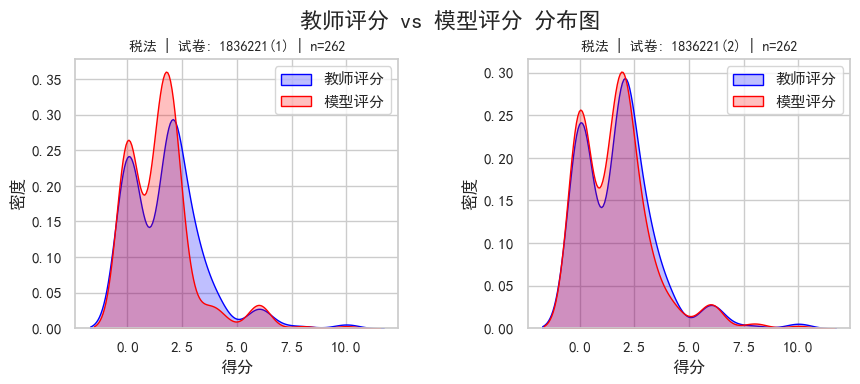

In [118]:
########### 两者评分情况分布图 ##########
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.gridspec as gridspec

matplotlib.rcParams['font.family'] = ['SimHei']           # 使用黑体显示中文
matplotlib.rcParams['axes.unicode_minus'] = False         # 正确显示负号


df = final_group_df1.copy()

# 每行图的高度，和每列的宽度# 图布局定义
row_height = 3.5
col_width = 5
subject_paper_dict = df.groupby('subject_name')['paper_id'].unique().to_dict()
subject_list = list(subject_paper_dict.keys())
fig_height = row_height * len(subject_list)
fig_width = col_width * max(len(p) for p in subject_paper_dict.values())

fig = plt.figure(figsize=(fig_width, fig_height), constrained_layout=True)
outer = gridspec.GridSpec(len(subject_list), 1, height_ratios=[1]*len(subject_list), hspace=0.5)

for i, subject in enumerate(subject_list):
    paper_ids = subject_paper_dict[subject]
    inner = gridspec.GridSpecFromSubplotSpec(1, len(paper_ids), subplot_spec=outer[i], wspace=0.4)
    
    for j, paper_id in enumerate(paper_ids):
        ax = plt.Subplot(fig, inner[j])
        sub_df = df[(df['subject_name'] == subject) & (df['paper_id'] == paper_id)]

        # KDE 分布
        sns.kdeplot(sub_df['teacher_score'], ax=ax, label='教师评分', color='blue', fill=True, warn_singular=False)
        sns.kdeplot(sub_df['model_score'], ax=ax, label='模型评分', color='red', fill=True, warn_singular=False)

        # # 题目分值显示
        # sns.rugplot(sub_df['question_score'], ax=ax, color='gray', height=0.05, lw=0.7)

        ax.set_title(f"{subject} | 试卷: {paper_id} | n={len(sub_df)}", fontsize=10)
        ax.set_xlabel("得分")
        ax.set_ylabel("密度")
        ax.legend()

        fig.add_subplot(ax)

plt.suptitle("教师评分 vs 模型评分 分布图", fontsize=16, y=1.02)
# ✅ 替代 tight_layout，防止 warning
plt.subplots_adjust(top=0.95, hspace=0.6, wspace=0.4)
plt.show()

In [ ]:
############# 不同题目分值两者打分分布 ############
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib

# 中文支持
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
matplotlib.rcParams['axes.unicode_minus'] = False

# 所有科目及其题目分值
df = final_group_df1.copy()
subjects = sorted(df['subject_name'].unique())
q_score_dict = {subj: sorted(df[df['subject_name'] == subj]['question_score'].unique()) for subj in subjects}
max_cols = max(len(v) for v in q_score_dict.values())

# 图形大小
fig_height = 4 * len(subjects)
fig_width = 5 * max_cols
fig = plt.figure(figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(len(subjects), max_cols, figure=fig)

for row_idx, subject in enumerate(subjects):
    q_scores = q_score_dict[subject]
    n_subplots = len(q_scores)
    
    # 计算起始列，让子图居中
    col_start = (max_cols - n_subplots) // 2

    for k, q_score in enumerate(q_scores):
        col_idx = col_start + k
        ax = fig.add_subplot(gs[row_idx, col_idx])
        sub_df = df[(df['subject_name'] == subject) & (df['question_score'] == q_score)]
        
        if not sub_df.empty:
            sns.kdeplot(sub_df['teacher_score'], ax=ax, label='教师评分', color='blue', fill=True, warn_singular=False)
            sns.kdeplot(sub_df['model_score'], ax=ax, label='模型评分', color='red', fill=True, warn_singular=False)
            ax.set_title(f"{subject} | 满分 {q_score} 分\nn={len(sub_df)}", fontsize=10)
            ax.set_xlabel("得分")
            ax.set_ylabel("密度")
            ax.legend()
        else:
            ax.axis('off')

fig.suptitle("所有科目 × 题目分值下 教师 vs 模型 评分分布图", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 给标题留空间
plt.show()

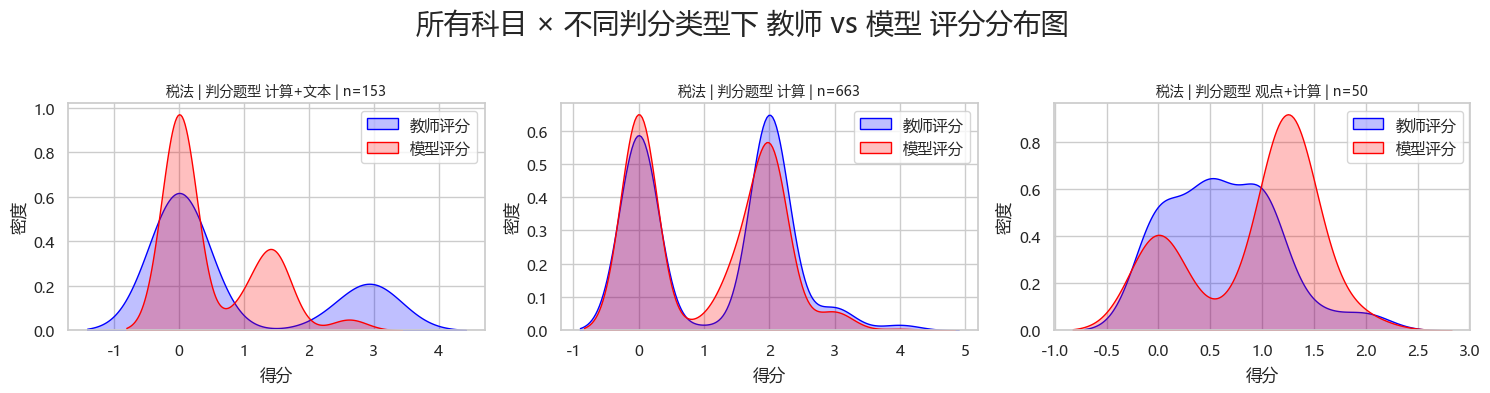

In [113]:
############# 不同题目分值两者打分分布 ############
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib

# 中文支持
matplotlib.rcParams['font.family'] = 'Microsoft YaHei'
matplotlib.rcParams['axes.unicode_minus'] = False

# 所有科目及其题目分值
df = final_df1.copy()
subjects = sorted(df['subject_name'].unique())
q_type_dict = {subj: df[df['subject_name'] == subj]['question_type'].unique() for subj in subjects}
max_cols = max(len(v) for v in q_type_dict.values())

# 图形大小
fig_height = 4 * len(subjects)
fig_width = 5 * max_cols
fig = plt.figure(figsize=(fig_width, fig_height))
gs = gridspec.GridSpec(len(subjects), max_cols, figure=fig)

for row_idx, subject in enumerate(subjects):
    q_types = q_type_dict[subject]
    n_subplots = len(q_types)
    
    # 计算起始列，让子图居中
    col_start = (max_cols - n_subplots) // 2

    for k, q_type in enumerate(q_types):
        col_idx = col_start + k
        ax = fig.add_subplot(gs[row_idx, col_idx])
        sub_df = df[(df['subject_name'] == subject) & (df['question_type'] == q_type)]
        
        if not sub_df.empty:
            sns.kdeplot(sub_df['teacher_score'], ax=ax, label='教师评分', color='blue', fill=True, warn_singular=False)
            sns.kdeplot(sub_df['model_score'], ax=ax, label='模型评分', color='red', fill=True, warn_singular=False)
            ax.set_title(f"{subject} | 判分题型 {q_type} | n={len(sub_df)}", fontsize=10)
            ax.set_xlabel("得分")
            ax.set_ylabel("密度")
            ax.legend()
        else:
            ax.axis('off')

fig.suptitle("所有科目 × 不同判分类型下 教师 vs 模型 评分分布图", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.96])  # 给标题留空间
plt.show()

